<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<br><b>Little Demo: Stellar CMD (Color-Magnitude Diagram)</b> <br>
Contact author(s): Jeff Carlin and Yumi Choi <br>
Last verified to run: 2024-01-19 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container Size: medium

Create a stellar color-magnitude diagram (CMD) and color-color diagram(s).

**Option** to create the same figures in the Portal in Section 5. <br>

## 1. Set up

Import packages.

In [1]:
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service, retrieve_query

Instantiate the TAP service.

In [2]:
service = get_tap_service("tap")

## 2. TAP query

Define the TAP query to retrieve ~70,000 point-like Objects in a 2-degree radius region. The Object catalog contains objects detected in deep coadds.

In [4]:
query = "SELECT scisql_nanojanskyToAbMag(g_psfFlux) as gmag, " + \
        "scisql_nanojanskyToAbMag(r_psfFlux) as rmag, " + \
        "scisql_nanojanskyToAbMag(i_psfFlux) as imag, " + \
        "scisql_nanojanskyToAbMag(z_psfFlux) as zmag, " + \
        "scisql_nanojanskyToAbMag(y_psfFlux) as ymag " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND i_extendedness = 0 AND z_extendedness = 0 " + \
        "AND i_psfFlux/i_psfFluxErr > 5 " + \
        "AND z_psfFlux/z_psfFluxErr > 5 " + \
        "AND y_psfFlux/y_psfFluxErr > 5 "

Execute the query, and store the results in an `astropy` table.

In [5]:
results = service.search(query).to_table()

Uncomment the following cell to view the table.

In [ ]:
# results

## 3. Create the CMD

Plot i-band magnitude vs. g-r color, then i-z color, as scatter plots.

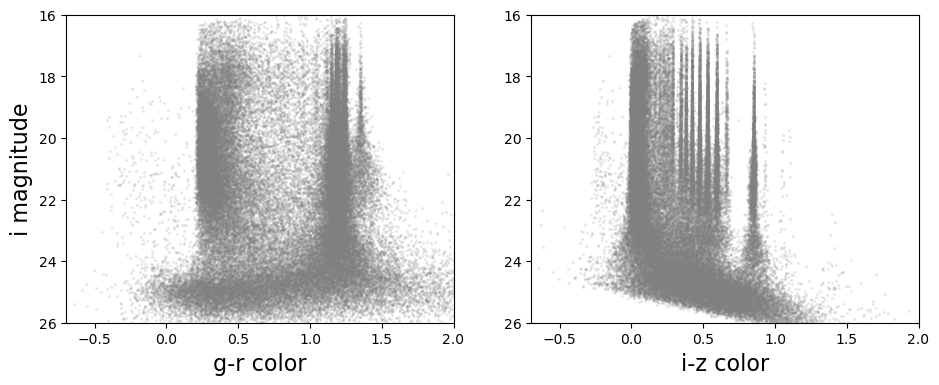

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
plt.sca(ax[0])
plt.plot(results['gmag'] - results['rmag'], results['imag'],
         'o', ms=2, color='grey', alpha=0.2, mew=0)
plt.xlabel('g-r color', fontsize=16)
plt.ylabel('i magnitude', fontsize=16)
plt.xlim(-0.7, 2)
plt.ylim(26, 16)
plt.sca(ax[1])
plt.plot(results['imag'] - results['zmag'], results['imag'],
         'o', ms=2, color='grey', alpha=0.2, mew=0)
plt.xlabel('i-z color', fontsize=16)
plt.xlim(-0.7, 2)
plt.ylim(26, 16)
plt.show()

Matplotlib offers a variety of <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">colormaps</a> to choose from.

Pick a different colormap.
Substitute its name in for "Greys" in the above code cell.
Re-execute the cell above to create a prettier plot.

Plot (r-i) vs. (g-r) colors:

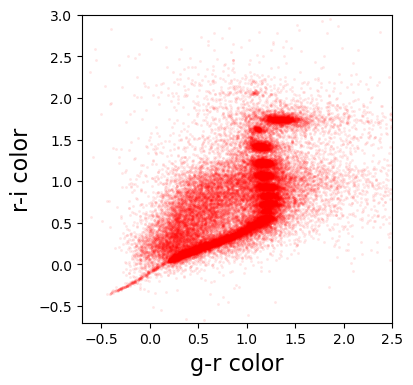

In [8]:
plt.figure(figsize=(4, 4))
plt.plot(results['gmag'] - results['rmag'], results['rmag'] - results['imag'],
         'o', ms=2, color='red', alpha=0.1, mew=0)
plt.xlabel('g-r color', fontsize=16)
plt.ylabel('r-i color', fontsize=16)
plt.ylim(-0.7, 3)
plt.xlim(-0.7, 2.5)
plt.show()

## 4. Examine red objects (likely cool dwarfs)

Plot a (z-y) vs. (i-z) color-color diagram:

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results['imag'] - results['zmag'], results['zmag'] - results['ymag'],
         'o', ms=2, color='grey', alpha=0.1, mew=0)
plt.xlabel('i-z color', fontsize=16)
plt.ylabel('z-y color', fontsize=16)
plt.ylim(-0.7, 2.0)
plt.xlim(-0.7, 2.5)
plt.show()

### Select candidate L dwarfs

Try a color-color selection to isolate the coolest (L-type?) dwarfs.

In [ ]:
cooldwarfs = (results['imag']-results['zmag'] > 1.0) & (results['zmag']-results['ymag'] > 1.0)

Highlight the selected points in a CMD and color-color diagram:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
plt.sca(ax[0])
plt.plot(results['imag'] - results['zmag'], results['imag'],
         'o', ms=2, color='grey', alpha=0.2, mew=0)
plt.plot(results[cooldwarfs]['imag'] - results[cooldwarfs]['zmag'], results[cooldwarfs]['zmag'],
         'o', ms=2, color='red', alpha=0.5, mew=0)
plt.xlabel('i-z color', fontsize=16)
plt.ylabel('i magnitude', fontsize=16)
plt.xlim(-0.7, 2)
plt.ylim(26, 16)
plt.sca(ax[1])
plt.plot(results['imag'] - results['zmag'], results['zmag'] - results['ymag'],
         'o', ms=2, color='grey', alpha=0.1, mew=0)
plt.plot(results[cooldwarfs]['imag'] - results[cooldwarfs]['zmag'],
         results[cooldwarfs]['zmag'] - results[cooldwarfs]['ymag'],
         'o', ms=2, color='red', alpha=0.5, mew=0)
plt.xlabel('i-z color', fontsize=16)
plt.ylim(-0.7, 2)
plt.xlim(-0.7, 2.5)
plt.show()

## 5. Repeat in the Portal

**Option** to execute the same query in the Portal.

5.1. Go to <a href="https://data.lsst.cloud/">data.lsst.cloud</a> in a new browser tab, and enter the Portal aspect.

5.2. In the Portal, next to “View” at the upper right, switch from the default “UI assisted” to “Edit ADQL”.

5.3. Copy and paste the following into the "ADQL Query" box.
```
SELECT scisql_nanojanskyToAbMag(g_psfFlux) as gmag,
scisql_nanojanskyToAbMag(r_psfFlux) as rmag,
scisql_nanojanskyToAbMag(i_psfFlux) as imag,
scisql_nanojanskyToAbMag(z_psfFlux) as zmag,
scisql_nanojanskyToAbMag(y_psfFlux) as ymag
FROM dp02_dc2_catalogs.Object
WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
               CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1
AND detect_isPrimary = 1
AND i_extendedness = 0 AND z_extendedness = 0
AND i_psfFlux/i_psfFluxErr > 5
AND z_psfFlux/z_psfFluxErr > 5
AND y_psfFlux/y_psfFluxErr > 5
```

5.4. At lower left, click "Search".
The Portal will transfer to the results view, which usually has three components (sky map, xy plot, and table).

5.6. Results view: since RA and Dec were not returned, the sky map either will not be shown or can be hidden by clicking the "xy-tbl" button at upper right.

5.7. View the default xy plot, a heatmap (2-d histogram) of g-band magnitude vs. r-band magnitude (i.e., the two columns of data returned).

5.8. Alter the default xy plot to be a CMD. Click on the double-gears icon at upper right to open the "Plot Parameters" pop-up window.

5.9. Change "X:" to "imag-zmag" and "Y:" to "imag", click "Apply", then click "Close". The Portal does not currently offer the capability to log scale the heatmap bin values.

<img src="figures/cmd-1-portal-screenshot.png" alt="Portal screenshot with final CMD." class="bg-primary" width="500px">
